<a href="https://colab.research.google.com/github/SaifAlthubaiti511/git-tutorial/blob/main/fluShotLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [23]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
# Import SimpleImputer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
# Import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score

**Loading the Datasets**

In [24]:
# Load the datasets
features_df = pd.read_csv('/content/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Training_Features.csv')
labels_df = pd.read_csv('/content/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Training_Labels.csv')

# Combine into one dataframe
df = pd.concat([features_df, labels_df], axis=1)

**Data Inspection**

In [25]:
# Display the first few rows of each dataset to understand their structure
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,2,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,3,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4,0,0


In [26]:
#The first few rows and data types of df_features
print(features_df.head())
print(features_df.dtypes)

   respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              0           1.0             0.0                        0.0   
1              1           3.0             2.0                        0.0   
2              2           1.0             1.0                        0.0   
3              3           1.0             1.0                        0.0   
4              4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                          0.0               

In [27]:
#The first few rows and data types of labels_df
print(labels_df.head())
print(labels_df.dtypes)

   respondent_id  h1n1_vaccine  seasonal_vaccine
0              0             0                 0
1              1             0                 1
2              2             0                 0
3              3             0                 1
4              4             0                 0
respondent_id       int64
h1n1_vaccine        int64
seasonal_vaccine    int64
dtype: object


# **EDA**

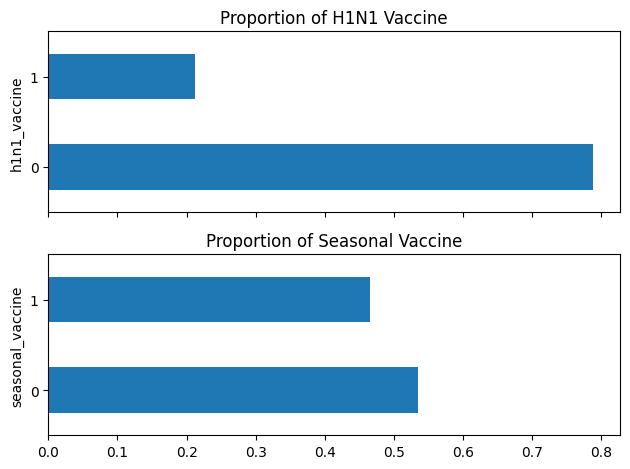

In [28]:
# Create subplots
fig, axes = plt.subplots(2, 1, sharex=True)

# Dataset size
n_obs = labels_df.shape[0]

# Vaccine data and titles for plotting
vaccine_info = [
    ('h1n1_vaccine', "Proportion of H1N1 Vaccine", axes[0]),
    ('seasonal_vaccine', "Proportion of Seasonal Vaccine", axes[1])
]

# Loop through each vaccine type and plot
for vaccine, title, ax in vaccine_info:
    proportion = labels_df[vaccine].value_counts().div(n_obs)
    proportion.plot.barh(ax=ax)
    ax.set_title(title)
    ax.set_ylabel(vaccine)

fig.tight_layout()


About half of the people got seasonal flu vaccine, but only 20% got the h1n1 vaccine. When we look at how many people got each vaccine, the seasonal flu vaccine numbers are balanced, but the H1N1 vaccine seems to be imballanced.

In [29]:
pd.crosstab(
    labels_df["h1n1_vaccine"],
    labels_df["seasonal_vaccine"],
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [30]:
# Phi Coefficient is the same as Pearson for two binary variables
df["h1n1_vaccine"].corr(labels_df["seasonal_vaccine"], method="pearson")

0.37714265306144495



*   A larger proportion of the sample received the seasonal vaccine compared to the H1N1 vaccine.

*   The proportion of people who did not receive any vaccine is the largest single category.

*   Most people who got the H1N1 vaccine had already gotten the seasonal flu vaccine. This shows that people who get the seasonal flu vaccine are also open to getting the H1N1 shot.


Rate plot

In [31]:
def rate_plot(col, target, data, ax=None):

    counts = (df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    #ax.legend().remove()

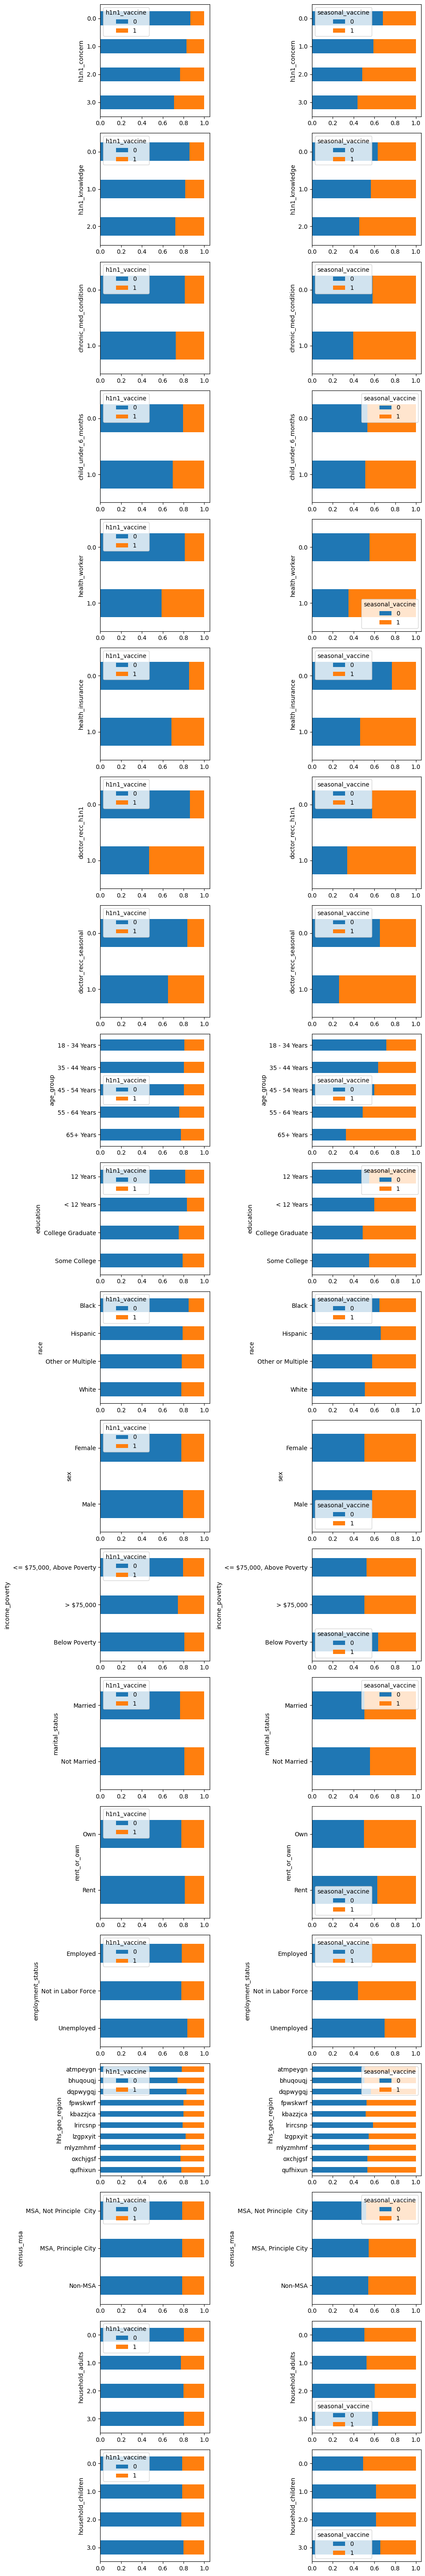

In [32]:
import matplotlib.pyplot as plt

# Define the columns to plot
columns_to_plot = [
    'h1n1_concern',
    'h1n1_knowledge',
    'chronic_med_condition',
    'child_under_6_months',
    'health_worker',
    'health_insurance',
    'doctor_recc_h1n1',
    'doctor_recc_seasonal',
    'age_group',
    'education',
    'race',
    'sex',
    'income_poverty',
    'marital_status',
    'rent_or_own',
    'employment_status',
    'hhs_geo_region',
    'census_msa',
    'household_adults',
    'household_children'
]

# Create a subplot grid layout: 2 rows (for each column) and 2 columns (for each target variable)
fig, axs = plt.subplots(len(columns_to_plot), 2, figsize=(10, 3 * len(columns_to_plot)))

# Loop through each column and plot
for i, col in enumerate(columns_to_plot):
    rate_plot(col, 'h1n1_vaccine', df, ax=axs[i, 0])
    rate_plot(col, 'seasonal_vaccine', df, ax=axs[i, 1])
    #axs[i, 0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine')
    #axs[i, 1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine')

fig.tight_layout()

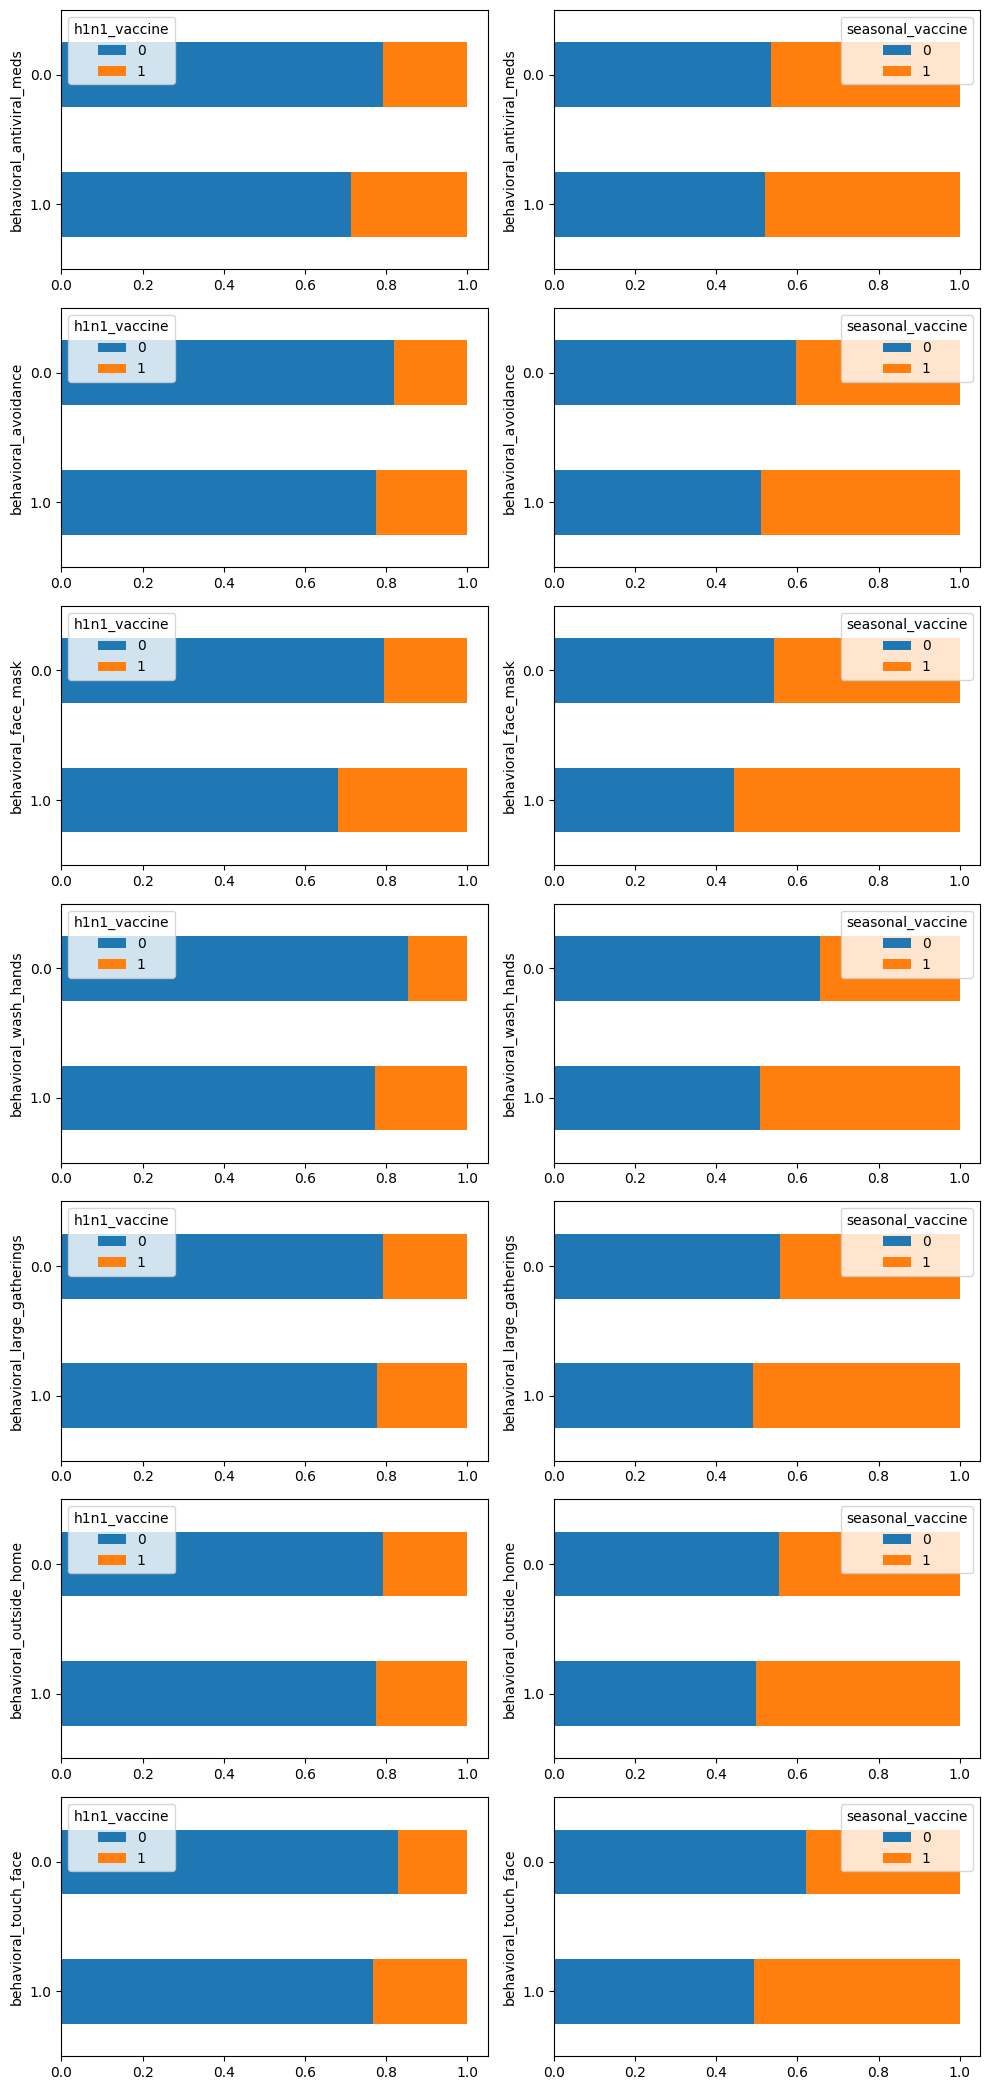

In [11]:
# Plot behaviorl columns

behavioral_columns = [
    'behavioral_antiviral_meds',
    'behavioral_avoidance',
    'behavioral_face_mask',
    'behavioral_wash_hands',
    'behavioral_large_gatherings',
    'behavioral_outside_home',
    'behavioral_touch_face']




# Create a subplot grid layout: 2 rows (for each column) and 2 columns (for each target variable)
fig, axs = plt.subplots(len(behavioral_columns), 2, figsize=(10, 3 * len(behavioral_columns)))

# Loop through each column and plot
for i, col in enumerate(behavioral_columns):
    rate_plot(col, 'h1n1_vaccine', df, ax=axs[i, 0])
    rate_plot(col, 'seasonal_vaccine', df, ax=axs[i, 1])
    #axs[i, 0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine')
    #axs[i, 1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine')

fig.tight_layout()

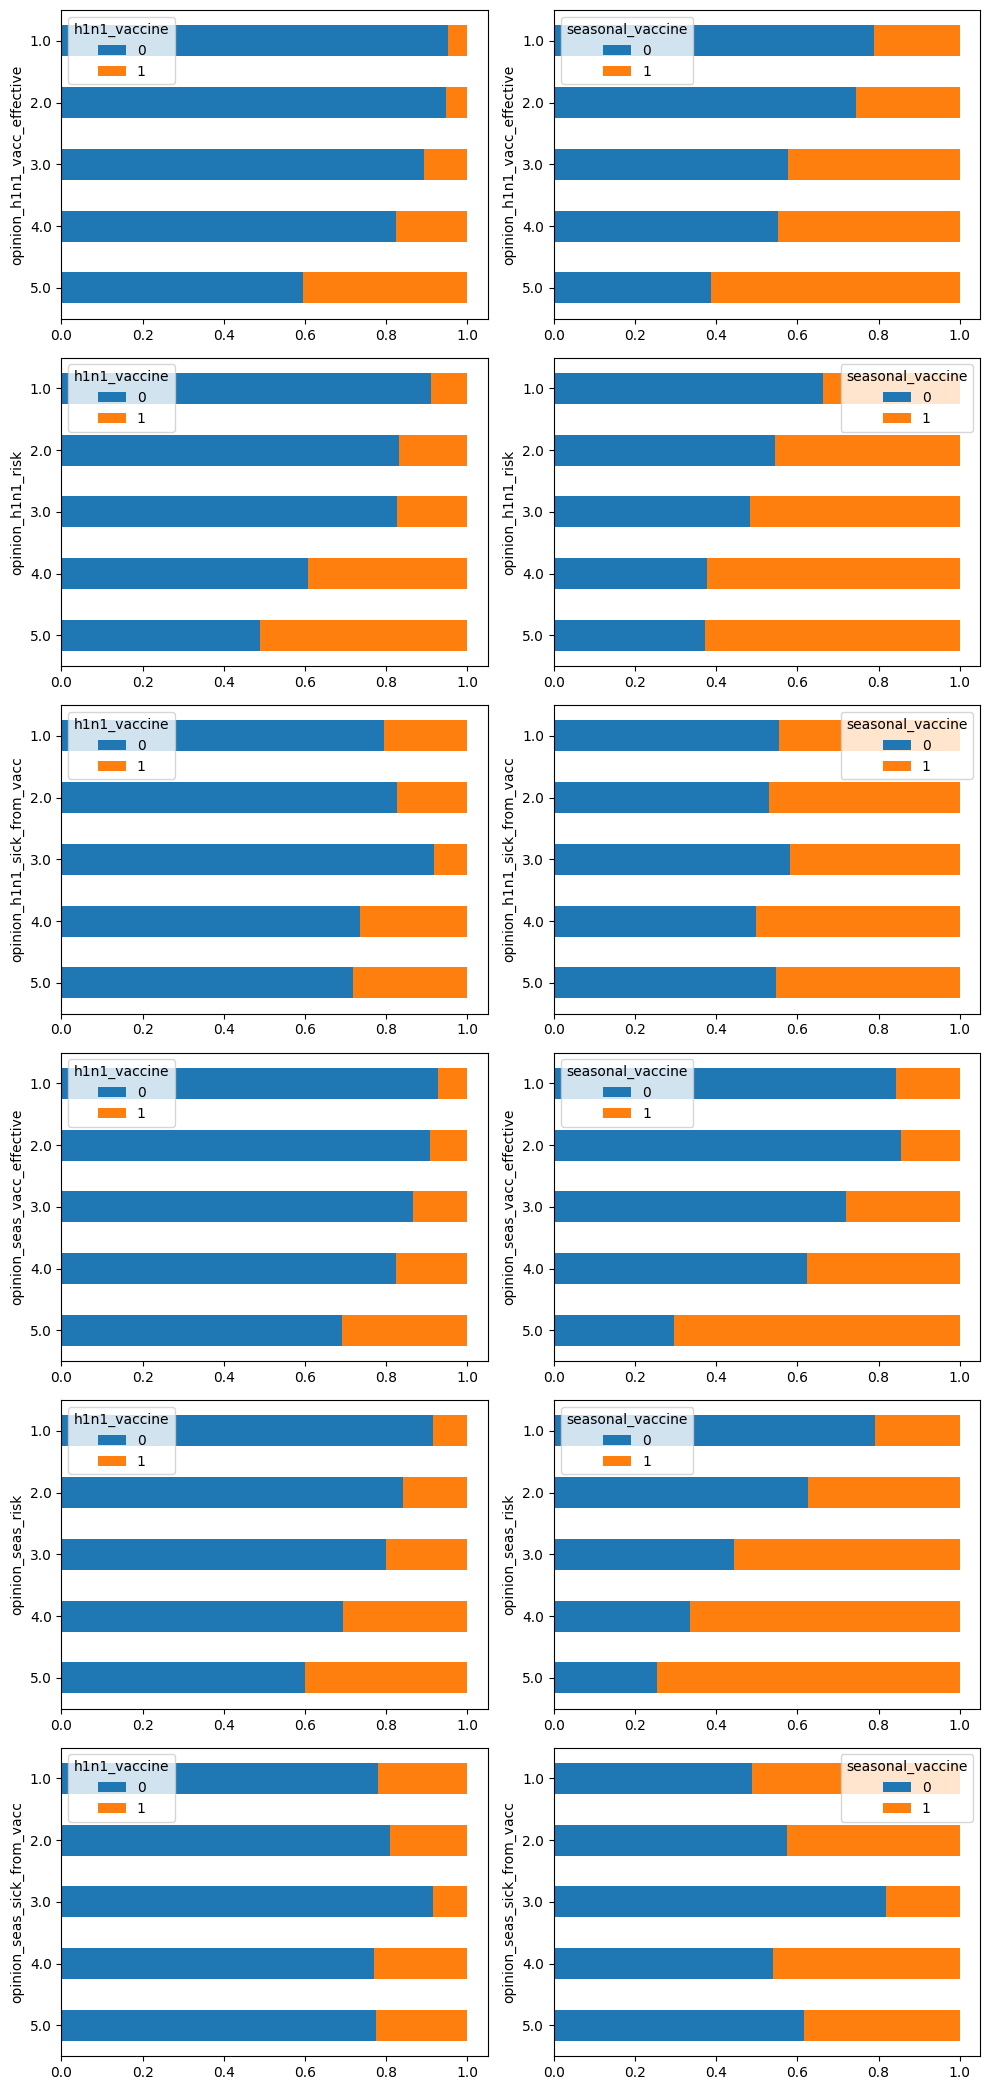

In [12]:
# Plot opinion columns

opinion_columns = [
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc']


# Create a subplot grid layout: 2 rows (for each column) and 2 columns (for each target variable)
fig, axs = plt.subplots(len(opinion_columns), 2, figsize=(10, 3 * len(behavioral_columns)))

# Loop through each column and plot
for i, col in enumerate(opinion_columns):
    rate_plot(col, 'h1n1_vaccine', df, ax=axs[i, 0])
    rate_plot(col, 'seasonal_vaccine', df, ax=axs[i, 1])
    #axs[i, 0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine')
    #axs[i, 1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine')

fig.tight_layout()

# **Data preprocessing**

Upon inspection, our dataset Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Training_Features we noticed:

1-Significant missing values in many columns: notable Columns with High Missing Rates: The employment_occupation, employment_industry, and health_insurance columns have a substantial proportion of missing values, exceeding 45% in some cases. Such a high level of missingness can introduce biases or inaccuracies in predictive models if not addressed appropriately.

2- Diverse Range of Feature Types our dataset comprises a mix of numerical, categorical, and binary features, reflecting a broad spectrum of factors that could influence vaccine uptake.

3-Given the nature of vaccine uptake data, there may be imbalances in the target variables (e.g., more individuals not receiving a vaccine than those who do). This can affect model performance, particularly for classification algorithms.

**Identifying Column Types:**
Numerical and categorical columns are identified to treat them appropriately during preprocessing. 'respondent_id' is removed from the numerical columns as it's not relevant for modeling.

In [15]:
# Identifying numerical and categorical columns
numerical_columns = features_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = features_df.select_dtypes(include=['object']).columns.tolist()

# Removing 'respondent_id' as it's not a feature for modeling
numerical_columns.remove('respondent_id')

**Imputing Missing Values:**
Imputation is done separately for numerical and categorical using SimpleImputer. For numerical columns, the median is used to fill missing values, while the most frequent category fills gaps in categorical columns. This step addresses missing data, ensuring the model has a complete dataset to learn from.

In [16]:
# Imputing missing values for numerical
numerical_imputer = SimpleImputer(strategy='median')
features_df[numerical_columns] = numerical_imputer.fit_transform(features_df[numerical_columns])

# For categorical
categorical_imputer = SimpleImputer(strategy='most_frequent')
features_df[categorical_columns] = categorical_imputer.fit_transform(features_df[categorical_columns])

**Encoding Categorical Variables:**
One-hot encoding is applied to categorical features to convert them into a format that can be provided to machine learning algorithms, enhancing model accuracy and interpretability.


In [17]:
# Encoding categorical variables
# One-hot encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_categorical = encoder.fit_transform(features_df[categorical_columns])
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
df_encoded_categorical_features = pd.DataFrame(encoded_categorical, columns=encoded_feature_names)

**Combining Features:**
Merging encoded categorical and numerical features into a single dataframe prepares the final dataset for model training. This step involves concatenating the preprocessed numerical and one-hot encoded categorical features, ensuring the model receives all relevant information.

In [18]:
# Combining encoded categorical features with numerical features
df_features_preprocessed = pd.concat([df[numerical_columns].reset_index(drop=True), df_encoded_categorical_features.reset_index(drop=True)], axis=1)

In [19]:
df_features_preprocessed.head(25)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


**Split data**

In [33]:
# Get X features
X = df_features_preprocessed
# Get y labels
y = labels_df

30% test data | 70% train data

In [34]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=68)